# Introduction

## Team Member

Nhóm 11 - Lớp 21KDL1

|Tên|MSSV|Ghi chú|
|---|---|---|
|Võ Thị Khánh Linh|21280070|Nhóm trưởng|
|Nguyễn Nhật Minh Thư|21280112|   |
|Nguyễn Đặng Anh Thư|21280111|   |

## Topic: Machine Translation

Machine translation (Máy dịch) là một lĩnh vực nghiên cứu quan trọng trong xử lý ngôn ngữ tự nhiên (NLP), nhằm mục đích phát triển các hệ thống tự động có thể dịch văn bản hoặc lời nói từ ngôn ngữ này sang ngôn ngữ khác. Trong bài làm của nhóm chúng em sẽ tập trung giải quyết bài toán dịch từ Tiếng Anh sang Tiếng Việt.

[Link Demo](https://huggingface.co/spaces/nnmthuw/CoGaiMoDuong)

# Build an end-to-end Machine Translation

## Import Library

In [ ]:
!pip install datasets underthesea evaluate opendatasets optuna bert_score gdown==4.5.4

In [2]:
from __future__ import unicode_literals, print_function, division
import os
import time
import re
import random
import gdown
import warnings
import opendatasets as od

import torch
import torch.nn as nn
from torchtext.vocab import Vectors
from torchtext.transforms import PadTransform
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
from torchtext.vocab import GloVe
from tqdm import tqdm
import optuna

import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from datasets import load_dataset
import nltk
nltk.download('punkt')
sns.set()
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

from bert_score import score
from bert_score import plot_example
import evaluate
from underthesea import word_tokenize, text_normalize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Để giải quyết bài toán này, nhóm em đã sử dụng 2 dataset:
1. Dataset đầu tiên lấy từ trên Kaggle "https://www.kaggle.com/datasets/hungnm/englishvietnamese-translation?rvi=1", với tên gọi English-Vietnamese translation.
2. Dataset thứ hai "mt_eng_vietnamese" lấy từ Hugging Face. Dataset "mt_eng_vietnamese" là phiên bản đã được tiền xử lý của  IWSLT'15 English-Vietnamese machine translation dataset, được thiết kế riêng cho các tác vụ dịch từ tiếng Anh sang tiếng Việt.

In [ ]:
# {"username":"nguynnhtminhth","key":"850c156608419b76d680def2a8752f6d"}
import opendatasets as od

od.download('https://www.kaggle.com/datasets/hungnm/englishvietnamese-translation') # insert ypu kaggle  username and key

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: nguynnhtminhth
Your Kaggle Key: ··········


100%|██████████| 6.81M/6.81M [00:00<00:00, 48.0MB/s]

- Đầu tiên ta sẽ load dataset từ Kaggle có tên là English-Vietnamese Translation.
- Folder Dataset được load về từ Kaggle sẽ gồm 2 file là **en_sents** và **vi_sents**.
- Sau đó tiến hành chia dataset thành 3 tập là train, test và validation với tỷ lệ lần lượt là 0.7, 0.15 và 0.15.
- Sau khi chia xong thì ta kết hợp cả ba tập lại và lưu vào DATASET để dễ thực hiện các công việc khác.

In [ ]:
# Load data from folder and combine it into DATASET
data_dir = "./englishvietnamese-translation/"
en_sents = open(data_dir + 'en_sents', "r", encoding = 'utf-8').read().splitlines()
vi_sents = open(data_dir + 'vi_sents', "r", encoding = 'utf-8').read().splitlines()

# Size of train, valid and test set
train_size, valid_size, test_size = 0.8, 0.1, 0.1

train = list()
valid = list()
test = list()

for i, (en, vi) in enumerate(zip(en_sents, vi_sents)):
    if i <= int(train_size* len(en_sents)):
        train.append({'en': en, 'vi': vi})
    elif i <= int((train_size + valid_size)* len(en_sents)):
        valid.append({'en': en, 'vi': vi})
    else:
        test.append({'en': en, 'vi': vi})

DATASET1 = {'train': train, 'valid': valid, 'test': test}

## Exploratory Data Analysis

Exploratory Data Analysis (EDA) có thể được định nghĩa là một quá trình khám phá tập dữ liệu thông qua trực quan hóa để quan sát xem có bất kỳ thông tin thú vị hoặc có giá trị nào không. Nói chung, đây là phương pháp điều tra ban đầu nhằm mục đích sử dụng cả phương pháp trực quan và định lượng để hiểu dữ liệu đang nói lên điều gì.

Đầu tiên là explore dataset English-Vietnamese Translation.

In [ ]:
# Check the available splits (e.g., train, validation, test)
DATASET1.keys()

dict_keys(['train', 'valid', 'test'])

In [ ]:
# Check the number of examples in each split
print("Train examples:", len(DATASET1["train"]))
print("Validation examples:", len(DATASET1["valid"]))
print("Test examples:", len(DATASET1["test"]))

Train examples: 203273
Validation examples: 25409
Test examples: 25408


In [ ]:
# Print a few examples from the dataset
for example in DATASET1["train"][1:6]:
    print("Source:", example["en"])
    print("Target:", example["vi"])
    print()

Source: Be quiet for a moment.
Target: im lặng một lát

Source: Read this
Target: đọc này

Source: Tom persuaded the store manager to give him back his money.
Target: tom thuyết phục người quản lý cửa hàng trả lại tiền cho anh ta.

Source: Friendship consists of mutual understanding
Target: tình bạn bao gồm sự hiểu biết lẫn nhau

Source: Are you going to come tomorrow?
Target: ngày mai bạn có đến không



In [ ]:
df1 = pd.DataFrame(DATASET1["train"])

In [ ]:
df1["vi_tokenized"] = df1["vi"].apply(lambda x: [word_tokenize(x)])

In [ ]:
df1["en_tokenized"] = df1["en"].apply(lambda x: [nltk.tokenize.word_tokenize(x)])

In [ ]:
def count_unique_tokens(row):
  token_counter = set()

  for token in row:
        # Check if the length of the token is greater than 0
        if len(token) > 0:
            for item in token:
              token_counter.add(item)

  return token_counter

In [ ]:
# Calculate the number of tokens in each column
en_token_counts = [len(count_unique_tokens(example)) for example in df1["en_tokenized"]]
vi_token_counts = [len(count_unique_tokens(example)) for example in df1["vi_tokenized"]]
average_num_source_tokens = sum(en_token_counts) / len(en_token_counts)
average_num_target_tokens = sum(vi_token_counts) / len(vi_token_counts)

# Print the statistics
print("Average the number of tokens in source sentence:", average_num_source_tokens)
print("Average the number of tokens in target sentences:", average_num_target_tokens)

Average the number of tokens in source sentence: 7.606101154604891
Average the number of tokens in target sentences: 7.451112543230041


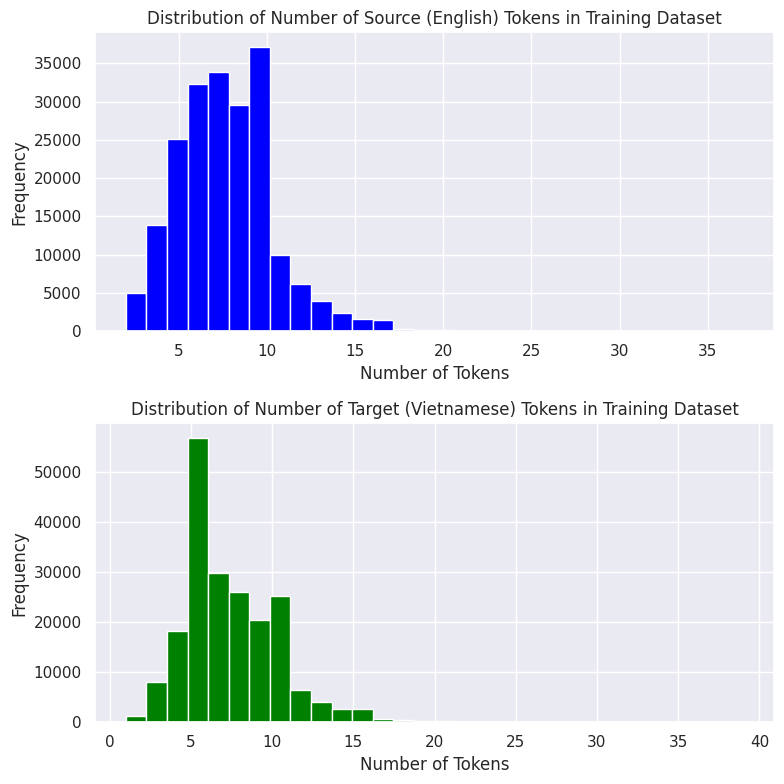

In [ ]:
# Create separate plots for English and Vietnamese tokens
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))

# English tokens plot
ax1.hist(en_token_counts, bins=30, color="blue")
ax1.set_title("Distribution of Number of Source (English) Tokens in Training Dataset")
ax1.set_xlabel("Number of Tokens")
ax1.set_ylabel("Frequency")

# Vietnamese tokens plot
ax2.hist(vi_token_counts, bins=30, color="green")
ax2.set_title("Distribution of Number of Target (Vietnamese) Tokens in Training Dataset")
ax2.set_xlabel("Number of Tokens")
ax2.set_ylabel("Frequency")

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

***(1) Redundant Data***

In [ ]:
df1.duplicated().sum()

6

Theo như kết quả, có 6 dữ liệu dư thừa trong bộ dữ liệu English-Vietnamese Translation. Cụ thể là 5 dữ liệu được in ra bên dưới.

In [ ]:
# Kiểm tra những dòng bị trùng lặp
duplicated_rows = df1.duplicated()

# In ra những dòng bị trùng lặp
duplicate_df1 = df1[duplicated_rows]
print(duplicate_df1)

                                                       en  \
90270                                Today is a sunny day   
90735                                   Deal us the cards   
112082  He'll have an accident one of these days if he...   
134198                              You're very beautiful   
140692               I had no idea you could speak French   
191542                                      I'm tired now   

                                                       vi  
90270                            hôm nay là một ngày nắng  
90735                        giải quyết chúng tôi các thẻ  
112082  Anh ấy sẽ gặp tai nạn một trong những ngày này...  
134198                                        Bạn rất đẹp  
140692           tôi không biết bạn có thể nói tiếng Pháp  
191542                                    bây giờ tôi mệt  


***(2) Incomplete Data***

In [ ]:
df1.isnull().sum(axis = 0)

en    0
vi    0
dtype: int64

Theo như kết quả trả về, không có dữ liệu không đầy đủ trong bất kỳ cột nào, điều này cho thấy rằng tất cả dữ liệu đã được điền đầy đủ vào mọi hàng và cột trong tập dữ liệu.

Tiếp theo là explore dataset "mt_eng_vietnamese".

In [ ]:
dataset = load_dataset("mt_eng_vietnamese", 'iwslt2015-en-vi')
DATASET2 = {'train': dataset['train']['translation'], 'valid': dataset['validation']['translation'], 'test': dataset['test']['translation']}

Generating train split:   0%|          | 0/133318 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1269 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1269 [00:00<?, ? examples/s]

In [ ]:
# Check the available splits (e.g., train, validation, test)
DATASET2.keys()

dict_keys(['train', 'valid', 'test'])

In [ ]:
# Check the number of examples in each split
print("Train examples:", len(DATASET2["train"]))
print("Validation examples:", len(DATASET2["valid"]))
print("Test examples:", len(DATASET2["test"]))

Train examples: 133318
Validation examples: 1269
Test examples: 1269


In [ ]:
# Print a few examples from the dataset
for example in DATASET2["train"][:5]:
    print("Source:", example["en"])
    print("Target:", example["vi"])
    print()

Source: Rachel Pike : The science behind a climate headline
Target: Khoa học đằng sau một tiêu đề về khí hậu

Source: In 4 minutes , atmospheric chemist Rachel Pike provides a glimpse of the massive scientific effort behind the bold headlines on climate change , with her team -- one of thousands who contributed -- taking a risky flight over the rainforest in pursuit of data on a key molecule .
Target: Trong 4 phút , chuyên gia hoá học khí quyển Rachel Pike giới thiệu sơ lược về những nỗ lực khoa học miệt mài đằng sau những tiêu đề táo bạo về biến đổi khí hậu , cùng với đoàn nghiên cứu của mình -- hàng ngàn người đã cống hiến cho dự án này -- một chuyến bay mạo hiểm qua rừng già để tìm kiếm thông tin về một phân tử then chốt .

Source: I &apos;d like to talk to you today about the scale of the scientific effort that goes into making the headlines you see in the paper .
Target: Tôi muốn cho các bạn biết về sự to lớn của những nỗ lực khoa học đã góp phần làm nên các dòng tít bạn thường th

In [ ]:
df2 = pd.DataFrame(dataset["train"])

In [ ]:
df2["en"] = df2["translation"].apply(lambda x: x["en"])
df2["vi"] = df2["translation"].apply(lambda x: x["vi"])

In [ ]:
df2["vi_tokenized"] = df2["vi"].apply(lambda x: [word_tokenize(x)])

In [ ]:
df2["en_tokenized"] = df2["en"].apply(lambda x: [nltk.tokenize.word_tokenize(x)])

In [ ]:
# Calculate the number of tokens in each column
en_token_counts_2 = [len(count_unique_tokens(example)) for example in df2["en_tokenized"]]
vi_token_counts_2 = [len(count_unique_tokens(example)) for example in df2["vi_tokenized"]]
average_num_source_tokens_2 = sum(en_token_counts_2) / len(en_token_counts_2)
average_num_target_tokens_2 = sum(vi_token_counts_2) / len(vi_token_counts_2)

# Print the statistics
print("Average the number of tokens in source sentence:", average_num_source_tokens_2)
print("Average the number of tokens in target sentences:", average_num_target_tokens_2)

Average the number of tokens in source sentence: 18.503337883856645
Average the number of tokens in target sentences: 17.93877045860274


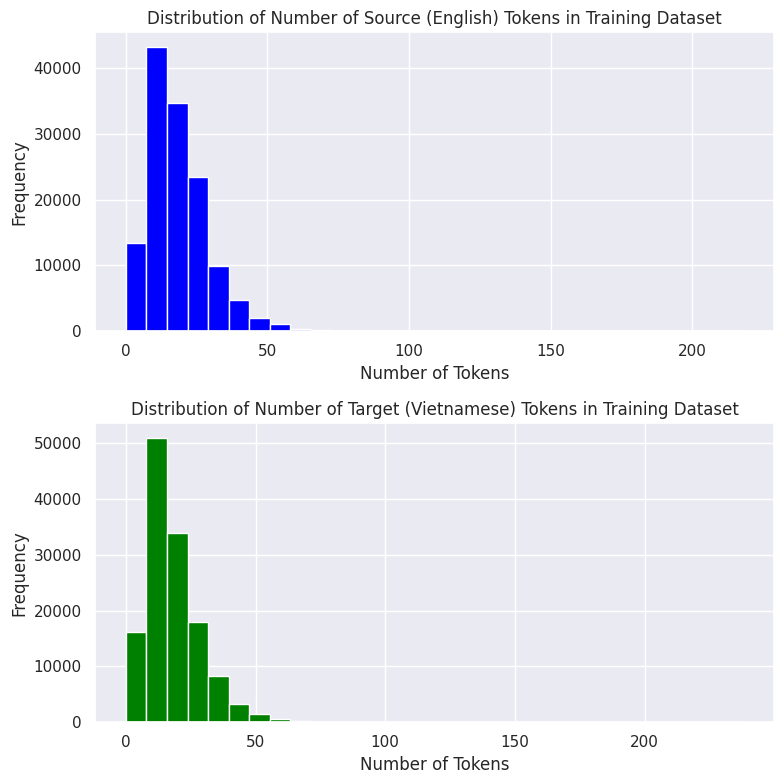

In [ ]:
# Create separate plots for English and Vietnamese tokens
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))

# English tokens plot
ax1.hist(en_token_counts_2, bins=30, color="blue")
ax1.set_title("Distribution of Number of Source (English) Tokens in Training Dataset")
ax1.set_xlabel("Number of Tokens")
ax1.set_ylabel("Frequency")

# Vietnamese tokens plot
ax2.hist(vi_token_counts_2, bins=30, color="green")
ax2.set_title("Distribution of Number of Target (Vietnamese) Tokens in Training Dataset")
ax2.set_xlabel("Number of Tokens")
ax2.set_ylabel("Frequency")

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

## Data Preparation

### Vocabulary

- Xây dựng Vocabulary như là một từ điển và có nhiệm vụ chính là để chuyển đổi từ các token sang các tensor và ngược lại.
- Một số token đặc biệt với id tương ứng là:
    + Token **\<sos\>** (Start of sentence Token) tương ứng với id = 0
    + Token **\<eos\>** (End of sentence Token) tương ứng với id = 1
    + Token **\<unk\>** (Unknown Token) tương ứng với id = 2
    + Token **\<pad\>** (Padding Token) tương ứng với id = 3

- Ngoài ra Vocabulary còn có một số phương thức quan trọng như:
    + **add**: Thêm từ vựng vào Vocab.
    + **preprocessing_sent**: Tiền xử lý câu đầu vào phụ thuộc vào ngôn ngữ (Anh/Việt) trước khi được đưa vào mô hình để train hay predict.
    + **tokenize_corpus**: Phân rã Corpus (Có thể hiểu là gồm nhiều câu) thành các tokens.

In [ ]:
# Build Vocabulary
MAX_LENGTH = 20
class Vocabulary:
    """The Vocabulary class is used to record words, which are used to convert
    text to numbers and vice versa.
    """

    def __init__(self, lang="vi"):
        self.lang = lang
        self.word2id = dict()
        self.word2id["<sos>"] = 0  # Start of Sentence Token
        self.word2id["<eos>"] = 1  # End of Sentence Token
        self.word2id["<unk>"] = 2  # Unknown Token
        self.word2id["<pad>"] = 3  # Pad Token
        self.sos_id = self.word2id["<sos>"]
        self.eos_id = self.word2id["<eos>"]
        self.unk_id = self.word2id["<unk>"]
        self.pad_id = self.word2id["<pad>"]
        self.id2word = {v: k for k, v in self.word2id.items()}
        self.pad_transform = PadTransform(max_length = MAX_LENGTH, pad_value = self.pad_id)

    def __getitem__(self, word):
        """Return ID of word if existed else return ID unknown token
        @param word (str)
        """
        return self.word2id.get(word, self.unk_id)

    def __contains__(self, word):
        """Return True if word in Vocabulary else return False
        @param word (str)
        """
        return word in self.word2id

    def __len__(self):
        """
        Return number of tokens(include sos, eos, unk and pad tokens) in Vocabulary
        """
        return len(self.word2id)

    def lookup_tokens(self, word_indexes: list):
        """Return the list of words by lookup by ID
        @param word_indexes (list(int))
        @return words (list(str))
        """
        return [self.id2word[word_index] for word_index in word_indexes]

    def add(self, word):
        """Add word to vocabulary
        @param word (str)
        @return index (str): index of the word just added
        """
        if word not in self:
            word_index = self.word2id[word] = len(self.word2id)
            self.id2word[word_index] = word
            return word_index
        else:
            return self[word]

    def preprocessing_sent(self, sent, lang="en"):
        """Preprocessing a sentence (depend on language english or vietnamese)
        @param sent (str)
        @param lang (str)
        """

        # Lowercase sentence and remove space at beginning and ending
        sent = sent.lower().strip()

        # Replace HTML charecterist
        sent = re.sub("&apos;", "'", sent)
        sent = re.sub("&quot;", '"', sent)
        sent = re.sub("&#91;", "[", sent)
        sent = re.sub("&#93;", "]", sent)

        # Remove unnecessary space
        sent = re.sub("(?<=\w)\.", " .", sent)

        # Normalizing the distance between tokens (word and punctuation)
        sent = re.sub("(?<=\w),", " ,", sent)
        sent = re.sub("(?<=\w)\?", " ?", sent)
        sent = re.sub("(?<=\w)\!", " !", sent)
        sent = re.sub(" +", " ", sent)

        if (lang == "en") or (lang == "eng") or (lang == "english"):
            # Replace short form
            sent = re.sub("what's", "what is", sent)
            sent = re.sub("who's", "who is", sent)
            sent = re.sub("which's", "which is", sent)
            sent = re.sub("who's", "who is", sent)
            sent = re.sub("here's", "here is", sent)
            sent = re.sub("there's", "there is", sent)
            sent = re.sub("it's", "it is", sent)

            sent = re.sub("i'm", "i am", sent)
            sent = re.sub("'re ", " are ", sent)
            sent = re.sub("'ve ", " have ", sent)
            sent = re.sub("'ll ", " will ", sent)
            sent = re.sub("'d ", " would ", sent)

            sent = re.sub("aren't", "are not", sent)
            sent = re.sub("isn't", "is not", sent)
            sent = re.sub("don't", "do not", sent)
            sent = re.sub("doesn't", "does not", sent)
            sent = re.sub("wasn't", "was not", sent)
            sent = re.sub("weren't", "were not", sent)
            sent = re.sub("won't", "will not", sent)
            sent = re.sub("can't", "can not", sent)
            sent = re.sub("let's", "let us", sent)

        else:
            # Package underthesea.text_normalize support to normalize vietnamese
            sent = text_normalize(sent)
        if not sent.endswith(('.', '!', '?')):
            sent = sent + ' .'
        return sent.strip()

    def tokenize_corpus(self, corpus, disable=False):
        """Split the documents of the corpus into words
        @param corpus (list(str)): list of documents
        @param disable (bool): notified or not
        @return tokenized_corpus (list(list(str))): list of words
        """
        if not disable:
            print("Tokenize the corpus...")
        tokenized_corpus = list()
        for document in tqdm(corpus, disable=disable):
            tokenized_document = ["<sos>"] + self.preprocessing_sent(document, self.lang).split(" ") + ["<eos>"]
            tokenized_corpus.append(tokenized_document)
        return tokenized_corpus

    def corpus_to_tensor(self, corpus, is_tokenized=False, disable=False):
        """Convert corpus to a list of indices tensor
        @param corpus (list(str) if is_tokenized==False else list(list(str)))
        @param is_tokenized (bool)
        @return indicies_corpus (list(tensor))
        """
        if is_tokenized:
            tokenized_corpus = corpus
        else:
            tokenized_corpus = self.tokenize_corpus(corpus, disable=disable)
        indicies_corpus = list()
        for document in tqdm(tokenized_corpus, disable=disable):
            indicies_document = torch.tensor(
                list(map(lambda word: self[word], document)), dtype=torch.int64
            )

            indicies_corpus.append(self.pad_transform(indicies_document))

        return indicies_corpus

    def tensor_to_corpus(self, tensor, disable=False):
        """Convert list of indices tensor to a list of tokenized documents
        @param indicies_corpus (list(tensor))
        @return corpus (list(list(str)))
        """
        corpus = list()
        for indicies in tqdm(tensor, disable=disable):
            document = list(map(lambda index: self.id2word[index.item()], indicies))
            corpus.append(document)

        return corpus

### Load Dataset

- Do việc hạn chế về tài nguyên cũng như thời gian thì chỉ xét các câu có độ dài không quá 20 tokens.
- Xây dựng class DatasetMT để lưu giữ các tập data như train, test, validation và dễ dàng sử dụng hơn.

In [ ]:
def create_dataset():
    dataset = {'train': DATASET1['train'] + DATASET2['train'], 'valid': DATASET1['valid'] +  DATASET2['valid'], 'test': DATASET1['test'] +  DATASET2['test']}
    return dataset

class DatasetMT(Dataset):
    def __init__(self, vocab_source, vocab_target, dataset, named_set = "train"):
        """
        @param vocab_in (Vocabulary): Vocabulary of Input (English)
        @param vocab_tag (Vocabulary): Vocabulary of Target (Vietnamese)
        @param named_set (str): ["train", "test", "valid"]
        """
        self.vocab_source = vocab_source
        self.vocab_target = vocab_target
        self.sos_id = vocab_source['<sos>']
        self.eos_id = vocab_source['<eos>']
        self.unk_id = vocab_source['<unk>']
        self.pad_id = vocab_source['<pad>']

        data = dataset[named_set]
        self.sources = list()
        self.targets = list()
        for pair in data:
            if (len(vocab_source.preprocessing_sent(pair['en'], lang = "en").split(" ")) <= MAX_LENGTH - 2) \
            and (len(vocab_target.preprocessing_sent(pair['vi'], lang = 'vi').split(" ")) <= MAX_LENGTH - 2):
                self.sources.append(pair['en'])
                self.targets.append(pair['vi'])

        self.tensor_inputs = self.vocab_source.corpus_to_tensor(self.sources)
        self.tensor_targets = self.vocab_target.corpus_to_tensor(self.targets)

    def __len__(self):
        return len(self.tensor_inputs)

    def __getitem__(self, idx):
        return self.tensor_inputs[idx], self.tensor_targets[idx]

In [ ]:
DATASET = create_dataset()

- Bước đầu tiên, ta phải xây dựng Vocabulary bằng các thêm các token được phân rã từ tập train vào trong Vocabulary. Ở đây có hai Vocabulary đó là vocab_source (Tức dành cho tiếng Anh) và vocab_target (Tức dành cho tiếng Việt).

In [ ]:
# Build Vocabulary
train = DATASET['train']
sources = []
targets = []

vocab_source = Vocabulary("en")
vocab_target = Vocabulary("vi")

for pair in train:
    if ((len(vocab_source.preprocessing_sent(pair['en'], lang = "en").split(" ")) <= MAX_LENGTH - 2) \
        and (len(vocab_target.preprocessing_sent(pair['vi'], lang = 'vi').split(" ")) <= MAX_LENGTH - 2)):
        sources.append(pair['en'])
        targets.append(pair['vi'])


source2tokens = vocab_source.tokenize_corpus(sources)
target2tokens = vocab_target.tokenize_corpus(targets)

for document in source2tokens:
    for word in document:
        vocab_source.add(word)
for document in target2tokens:
    for word in document:
        vocab_target.add(word)

Tokenize the corpus...


100%|██████████| 257905/257905 [00:12<00:00, 20245.29it/s]


Tokenize the corpus...


100%|██████████| 257905/257905 [00:44<00:00, 5852.32it/s]


In [ ]:
# Build Dataset of Train, Test and Valid
train_dataset = DatasetMT(vocab_source, vocab_target, DATASET, named_set = "train")
valid_dataset = DatasetMT(vocab_source, vocab_target, DATASET, named_set = "valid")
test_dataset = DatasetMT(vocab_source, vocab_target, DATASET, named_set = "test")

# Build Dataloader with batch_size = 256
BATCH_SIZE = 256
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
val_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

Tokenize the corpus...


100%|██████████| 257905/257905 [00:06<00:00, 37470.00it/s]


Tokenize the corpus...


100%|██████████| 257905/257905 [00:06<00:00, 40478.31it/s]


Tokenize the corpus...


100%|██████████| 25302/25302 [00:00<00:00, 32044.41it/s]


Tokenize the corpus...


100%|██████████| 25302/25302 [00:00<00:00, 46052.45it/s]


Tokenize the corpus...


100%|██████████| 25362/25362 [00:00<00:00, 48219.55it/s]


Tokenize the corpus...


100%|██████████| 25362/25362 [00:00<00:00, 31801.67it/s]


### Transfer Learning

- Transfer Learning nói chung là một phương pháp giúp ta tận dụng các mô hình, kiến thức đã sử dụng để giải quyết tốt các bài toán liên quan để áp dụng nhằm cải thiện kết quả cũng như hiệu năng của một bài toán, mô hình khác.
- Ở đây ta sử dụng các Pre-trained Word2Vec Model, cụ thể thì Word2Vec hay Embedding là một cách để ta chuyển từ các tensor (gồm các "Id" đã được chuyển từ chuỗi token ở dạng list str) sang các tensor khác thông qua layer embedding. Các tensor sau khi qua layer này sẽ trở thành các tensor embedding gần nhau nếu các token có ý nghĩa hoặc tương quan cao và ngược lại thì các tensor embedding sẽ ở xa nhau nếu các token không có nhiều sự tương quan.
    + Word2Vec cho Vocabulary English là Glove với 400.000 từ vựng và embedding dim = 100
    + Word2Vec cho Vocabulary Vietnamese của PhoW2V với khoảng gần 1B từ vựng và embedding dim = 100

In [ ]:
## Pre-trained Embedding (Word2Vec) of English
vec_input = GloVe(name='6B', dim=100)
input_embedding = torch.zeros((len(vocab_source), 100))
words_found = 0

for i, word in enumerate(vocab_source.word2id):
    try:
        input_embedding[i] = vec_input.get_vecs_by_tokens(word)
        words_found += 1
    except KeyError:
        continue

.vector_cache/glove.6B.zip: 862MB [02:39, 5.40MB/s]                           
100%|█████████▉| 399999/400000 [00:22<00:00, 17710.76it/s]


In [ ]:
!gdown --id 1MfGxQOrw-LnOc-O_u-pMEX8MtgiyXuPr

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1MfGxQOrw-LnOc-O_u-pMEX8MtgiyXuPr
To: /content/word2vec_vi_syllables_100dims.txt
100% 1.18G/1.18G [00:12<00:00, 91.9MB/s]


In [ ]:
## Pre-trained Embedding (Word2Vec) of Vietnamese
vec_output = Vectors(name="/content/word2vec_vi_syllables_100dims.txt", unk_init=torch.Tensor.normal_)
output_embedding = torch.zeros((len(vocab_target), 100))
words_found = 0

for i, word in enumerate(vocab_target.word2id):
    try:
        output_embedding[i] = vec_output.get_vecs_by_tokens(word)
        words_found += 1
    except KeyError:
        continue

100%|██████████| 979460/979460 [00:53<00:00, 18417.11it/s]


In [ ]:
def create_input_emb_layer(pretrained = False):
    if not pretrained:
        weights_matrix = torch.zeros((len(vocab_source), 100))
    else:
        weights_matrix = input_embedding
    num_embeddings, embedding_dim = weights_matrix.size()
    emb_layer = nn.Embedding(num_embeddings, embedding_dim)
    emb_layer.weight.data = weights_matrix
    emb_layer.weight.requires_grad = False

    return emb_layer, embedding_dim

def create_output_emb_layer(pretrained = False):
    if not pretrained:
        weights_matrix = torch.zeros((len(vocab_target), 100))
    else:
        weights_matrix = output_embedding
    num_embeddings, embedding_dim = weights_matrix.size()
    emb_layer = nn.Embedding(num_embeddings, embedding_dim)
    emb_layer.weight.data = weights_matrix
    emb_layer.weight.requires_grad = False

    return emb_layer, embedding_dim

## Model Architecture

### Methodology

Kiến trúc neural network này được gọi là mô hình end-to-end (còn được gọi là seq2seq hay Encoder-Decoder) và bao gồm hai mạng RNN gọi là bộ mã hóa (Encoder) và bộ giải mã (Decoder).

Bộ mã hóa đọc một chuỗi đầu vào và đưa ra một vector duy nhất, và bộ giải mã đọc vector đó để tạo ra một chuỗi đầu ra. Khác với việc dự đoán chuỗi với một RNN duy nhất, nơi mỗi đầu vào tương ứng với một đầu ra, mô hình seq2seq giúp giải phóng chúng ta khỏi độ dài và thứ tự của chuỗi, điều này làm cho nó lý tưởng cho việc dịch giữa hai ngôn ngữ.

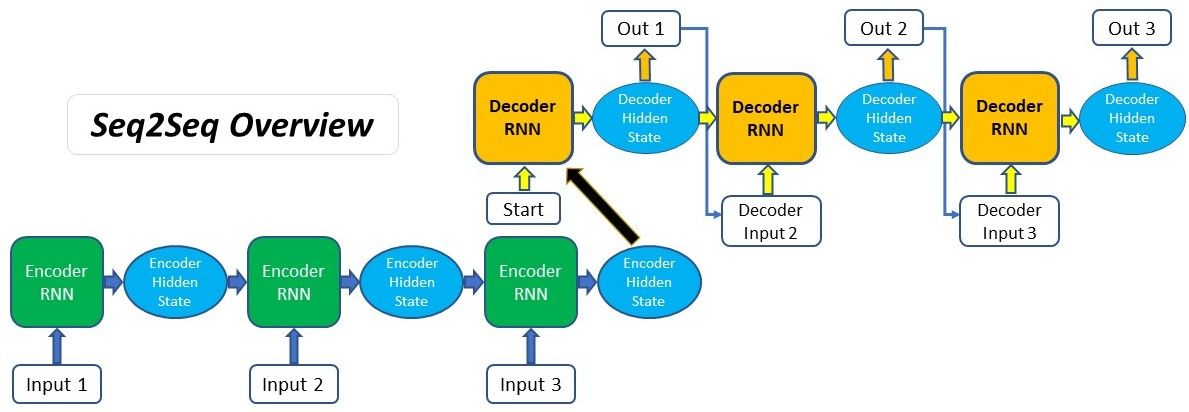

Áp dụng kỹ thuật Teacher Forcing - chiến lược huấn luyện Recurrent Neural Network sử dụng dữ liệu thực tế (ground truth) làm đầu vào, thay vì sử dụng đầu ra của mô hình từ một bước thời gian trước làm đầu vào.

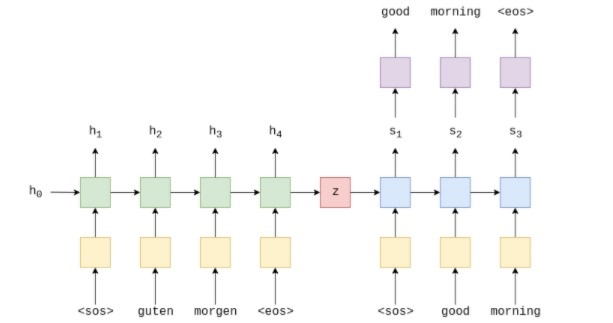

Cơ chế Attention mang lại một số lợi ích so với các mô hình seq2seq thông thường, như hiệu suất và độ chính xác cải thiện trên các chuỗi dài và phức tạp. Điều này được đạt được bằng cách giảm thiểu mất thông tin và gánh nặng lên hidden states. Hơn nữa, cơ chế chú ý cung cấp khả năng diễn giải và minh bạch cho các mô hình seq2seq, thông qua việc trực quan hóa trọng số chú ý và cho thấy các phần của chuỗi đầu vào và đầu ra quan trọng hoặc liên quan hơn cho nhiệm vụ.

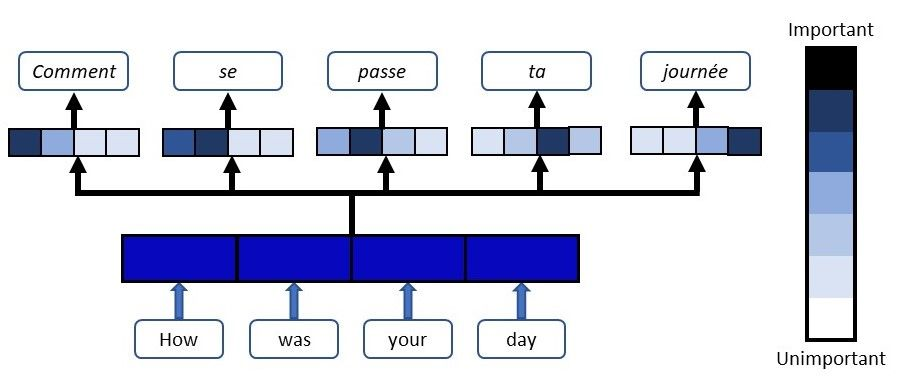

Cơ chế Attention chọn sử dụng là Bahdanau Attention vì nó có khả năng xử lý các chuỗi đầu vào dài và mô hình rõ ràng sự tương quan giữa các chuỗi đầu vào và đầu ra, điều này có thể dẫn đến các bản dịch chính xác hơn.

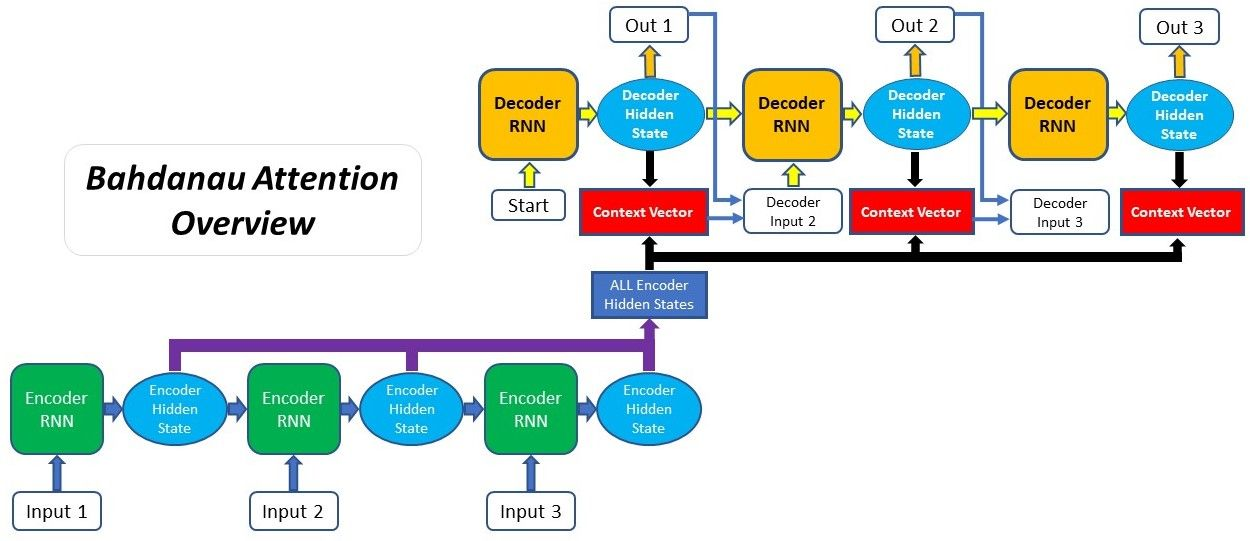

### Model

#### Architecture 1

- Seq2Seq

In [ ]:
class EncoderSeq2Seq(nn.Module):
    def __init__(self, input_size, hidden_size, dropout=0.1):
        super(EncoderSeq2Seq, self).__init__()
        self.hidden_size = hidden_size
        self.embedding, self.embedding_dim = create_input_emb_layer(True)
        self.gru = nn.GRU(self.embedding_dim, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden

class DecoderSeq2Seq(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderSeq2Seq, self).__init__()
        self.embedding, self.embedding_dim = create_output_emb_layer(True)
        self.gru = nn.GRU(self.embedding_dim, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(0)
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden  = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden, None # We return `None` for consistency in the training loop

    def forward_step(self, input, hidden):
        output = self.embedding(input)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.out(output)
        return output, hidden

#### Architecture 2

- Seq2Seq includes Attention Mechanism

In [ ]:
class EncoderAtt(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout = 0.1):
        """ Encoder RNN
        @param input_dim (int): size of vocab_souce
        @param hidden_dim (int)
        @param dropout (float): dropout ratio of layer drop out
        """
        super(EncoderAtt, self).__init__()
        self.hidden_dim = hidden_dim
        # Using pretrained Embedding
        self.embedding, self.embedding_dim = create_input_emb_layer(True)
        self.gru = nn.GRU(self.embedding_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        embedded = self.dropout(self.embedding(src))
        output, hidden = self.gru(embedded)
        return output, hidden

class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        """ Bahdanau Attention
        @param hidden_size (int)
        """
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)

        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)

        return context, weights

class DecoderAtt(nn.Module):
    def __init__(self, hidden_size, output_size, dropout=0.1):
        """ Decoder RNN using Attention
        @param hidden_size (int)
        @param output_size (int): size of vocab_target
        @param dropout (float): dropout ratio of layer drop out
        """
        super(DecoderAtt, self).__init__()
        # Using pretrained Embedding
        self.embedding, self.embedding_dim = create_output_emb_layer(True)
        self.fc = nn.Linear(self.embedding_dim, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(0)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            # Teacher forcing
            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions


    def forward_step(self, input, hidden, encoder_outputs):
        embedded =  self.dropout(self.fc(self.embedding(input)))

        query = hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

## Training

In [ ]:
def train_model(dataloader, encoder, decoder, en_optimizer, de_optimizer, criterion, device, teacher_forcing_ratio = 0.5, disable = False):
    """
    @param dataloader (DataLoader)
    @param encoder (EncoderAtt)
    @param decoder (DecoderAtt)
    @param en_optimizer (torch.optim): optimizer of encoder
    @param de_optimizer (torch.optim): optimizer of decoder
    @param criterion (torch.nn.modules.loss)
    @param device (torch.device)
    @param teacher_forcing_ratio (float): ratio to decide to use teacher forcing or not
    @return epoch_loss (float): model"s loss of this epoch
    """
    epoch_loss = 0
    encoder.train()
    decoder.train()
    for batch in (pbar:=tqdm(dataloader, disable = disable)):
        en_optimizer.zero_grad()
        de_optimizer.zero_grad()

        # forward pass
        input_tensor, target_tensor = batch
        input_tensor = input_tensor.to(device)
        target_tensor = target_tensor.to(device)

        use_teacher_forching = True if random.random() < teacher_forcing_ratio else False

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        if use_teacher_forching:
            decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)
        else:
            decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, None)

        # backward pass and update params
        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        pbar.set_postfix(loss=loss.item())
        epoch_loss += loss.item()

    return epoch_loss / len(dataloader)

def evaluate_model(dataloader, encoder, decoder, criterion, device):
    """
    @param dataloader (DataLoader)
    @param encoder (EncoderAtt)
    @param decoder (DecoderAtt)
    @param criterion (torch.nn.modules.loss)
    @param device (torch.device)
    @return epoch_loss (float): model's loss of this epoch
    """
    epoch_loss = 0

    with torch.no_grad():
        for batch in dataloader:
            input_tensor, target_tensor = batch
            input_tensor = input_tensor.to(device)
            target_tensor = target_tensor.to(device)

            encoder_outputs, encoder_hidden = encoder(input_tensor)
            # decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)
            ## Dont use teacher forcing
            decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, None)

            loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
            )
            epoch_loss += loss.item()

    return epoch_loss / len(dataloader)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def fit_model(encoder, decoder, train_dataloader, val_dataloader, en_optimizer, de_optimizer, loss_fn, device, num_epochs = 30, disable = False):
    """ Training model with number of epochs
    @param encoder (EncoderSeq2Seq or EncoderAtt)
    @param decoder (DecoderSeq2Seq or DecoderAtt)
    @param train_dataloader (DataLoader)
    @param val_dataloader (DataLoader)
    @param en_optimizer (torch.optim): optimizer of encoder
    @param de_optimizer (torch.optim): optimizer of decoder
    @param loss (torch.nn.modules.loss)
    @param device (torch.device)
    @param num_epochs (int)
    @param disable (bool)
    """
    training_loss = []
    validation_loss = []
    best_valid_loss = float('inf')
    if isinstance(encoder, EncoderSeq2Seq):
        encoder_name = "encoderseq2seq"
        decoder_name = "decoderseq2seq"
    else:
        encoder_name = "encoderatt"
        decoder_name = "decoderatt"

    for epoch in range(num_epochs):
        start_time = time.time()
        train_loss = train_model(train_dataloader, encoder, decoder, en_optimizer, de_optimizer, loss_fn, device, disable = False)
        valid_loss = evaluate_model(val_dataloader, encoder, decoder, loss_fn, device)
        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        if epoch % 1 == 0:
            print(f"Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s")
            print(f"\tTrain Loss: {train_loss:.3f} | Val. Loss: {valid_loss:.3f}")

        training_loss.append(train_loss)
        validation_loss.append(valid_loss)

        torch.save(encoder.state_dict(), f'./ckpts/{encoder_name}_epoch_{epoch+36}.pt')
        torch.save(decoder.state_dict(), f'./ckpts/{decoder_name}_epoch_{epoch+36}.pt')

    return training_loss, validation_loss

In [ ]:
## Folder to save checkpoints of model
if not os.path.exists("./ckpts"):
    os.mkdir("./ckpts")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Architecture 1

In [ ]:
## Define Model Seq2Seq with Attention
INPUT_DIM = len(vocab_source)
OUTPUT_DIM = len(vocab_target)
HID_DIM = 512

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

encoder = EncoderSeq2Seq(INPUT_DIM, HID_DIM).to(device)
decoder = DecoderSeq2Seq(HID_DIM, OUTPUT_DIM).to(device)

encoder_optimizer = torch.optim.AdamW(encoder.parameters())
decoder_optimizer = torch.optim.AdamW(decoder.parameters())
loss_fn = nn.NLLLoss()

print(encoder)
print(decoder)

cuda
EncoderSeq2Seq(
  (embedding): Embedding(31658, 100)
  (gru): GRU(100, 512, batch_first=True)
  (dropout): Dropout(p=0.1, inplace=False)
)
DecoderSeq2Seq(
  (embedding): Embedding(12756, 100)
  (gru): GRU(100, 512, batch_first=True)
  (out): Linear(in_features=512, out_features=12756, bias=True)
)


In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The encoder has {count_parameters(encoder):,} trainable parameters')
print(f'The decoder has {count_parameters(decoder):,} trainable parameters')

The encoder has 943,104 trainable parameters
The decoder has 7,486,932 trainable parameters


In [ ]:
training_loss, validation_loss = fit_model(encoder, decoder, train_dataloader, val_dataloader, encoder_optimizer, decoder_optimizer, loss_fn, device, num_epochs = 20, disable = False)

100%|██████████| 1008/1008 [01:42<00:00,  9.81it/s, loss=2.94]


Epoch: 01 | Epoch Time: 1m 46s
	Train Loss: 2.513 | Val. Loss: 2.232


100%|██████████| 1008/1008 [01:46<00:00,  9.46it/s, loss=3.13]


Epoch: 02 | Epoch Time: 1m 50s
	Train Loss: 1.965 | Val. Loss: 1.891


100%|██████████| 1008/1008 [01:49<00:00,  9.19it/s, loss=2.48]


Epoch: 03 | Epoch Time: 1m 53s
	Train Loss: 1.732 | Val. Loss: 1.773


100%|██████████| 1008/1008 [01:46<00:00,  9.47it/s, loss=2.35]


Epoch: 04 | Epoch Time: 1m 50s
	Train Loss: 1.594 | Val. Loss: 1.664


100%|██████████| 1008/1008 [01:45<00:00,  9.57it/s, loss=2.72]


Epoch: 05 | Epoch Time: 1m 49s
	Train Loss: 1.489 | Val. Loss: 1.647


100%|██████████| 1008/1008 [01:42<00:00,  9.83it/s, loss=2.6]


Epoch: 06 | Epoch Time: 1m 46s
	Train Loss: 1.427 | Val. Loss: 1.578


100%|██████████| 1008/1008 [01:42<00:00,  9.85it/s, loss=2.75]


Epoch: 07 | Epoch Time: 1m 46s
	Train Loss: 1.355 | Val. Loss: 1.575


100%|██████████| 1008/1008 [01:43<00:00,  9.79it/s, loss=1.98]


Epoch: 08 | Epoch Time: 1m 47s
	Train Loss: 1.327 | Val. Loss: 1.532


100%|██████████| 1008/1008 [01:42<00:00,  9.81it/s, loss=1.89]


Epoch: 09 | Epoch Time: 1m 46s
	Train Loss: 1.279 | Val. Loss: 1.526


100%|██████████| 1008/1008 [01:42<00:00,  9.83it/s, loss=2.44]


Epoch: 10 | Epoch Time: 1m 46s
	Train Loss: 1.249 | Val. Loss: 1.498


100%|██████████| 1008/1008 [01:42<00:00,  9.82it/s, loss=2.37]


Epoch: 11 | Epoch Time: 1m 46s
	Train Loss: 1.219 | Val. Loss: 1.487


100%|██████████| 1008/1008 [01:42<00:00,  9.79it/s, loss=1.77]


Epoch: 12 | Epoch Time: 1m 47s
	Train Loss: 1.190 | Val. Loss: 1.478


100%|██████████| 1008/1008 [01:42<00:00,  9.86it/s, loss=2.47]


Epoch: 13 | Epoch Time: 1m 46s
	Train Loss: 1.158 | Val. Loss: 1.521


100%|██████████| 1008/1008 [01:42<00:00,  9.80it/s, loss=2.23]


Epoch: 14 | Epoch Time: 1m 46s
	Train Loss: 1.166 | Val. Loss: 1.479


100%|██████████| 1008/1008 [01:42<00:00,  9.82it/s, loss=2.2]


Epoch: 15 | Epoch Time: 1m 46s
	Train Loss: 1.136 | Val. Loss: 1.471


100%|██████████| 1008/1008 [01:42<00:00,  9.81it/s, loss=1.63]


Epoch: 16 | Epoch Time: 1m 46s
	Train Loss: 1.127 | Val. Loss: 1.463


100%|██████████| 1008/1008 [01:42<00:00,  9.83it/s, loss=2.15]


Epoch: 17 | Epoch Time: 1m 46s
	Train Loss: 1.110 | Val. Loss: 1.481


100%|██████████| 1008/1008 [01:42<00:00,  9.80it/s, loss=1.54]


Epoch: 18 | Epoch Time: 1m 47s
	Train Loss: 1.104 | Val. Loss: 1.483


100%|██████████| 1008/1008 [01:42<00:00,  9.84it/s, loss=2.14]


Epoch: 19 | Epoch Time: 1m 46s
	Train Loss: 1.072 | Val. Loss: 1.475


100%|██████████| 1008/1008 [01:42<00:00,  9.82it/s, loss=2.05]


Epoch: 20 | Epoch Time: 1m 46s
	Train Loss: 1.070 | Val. Loss: 1.468


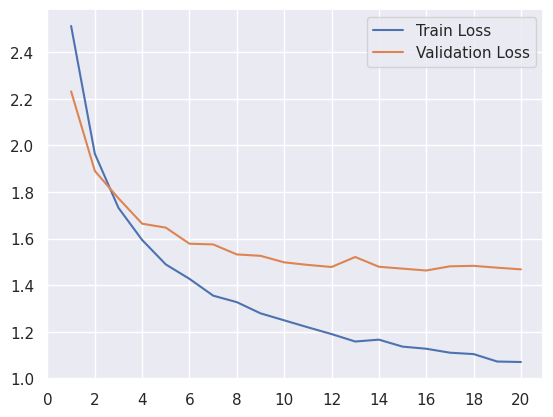

In [ ]:
plt.figure()
plt.plot(range(1,len(training_loss)+1), training_loss, label = 'Train Loss')
plt.plot(range(1,len(validation_loss)+1), validation_loss, label = 'Validation Loss')
plt.xticks(np.arange(0, 21, 2))
plt.legend()
plt.show()

### Architecture 2

In [ ]:
## Define Model Seq2Seq with Attention
INPUT_DIM = len(vocab_source)
OUTPUT_DIM = len(vocab_target)
HID_DIM = 512

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

encoder = EncoderAtt(INPUT_DIM, HID_DIM).to(device)
decoder = DecoderAtt(HID_DIM, OUTPUT_DIM).to(device)

encoder_optimizer = torch.optim.AdamW(encoder.parameters())
decoder_optimizer = torch.optim.AdamW(decoder.parameters())
loss_fn = nn.NLLLoss()

print(encoder)
print(decoder)

cuda
EncoderAtt(
  (embedding): Embedding(31658, 100)
  (gru): GRU(100, 512, batch_first=True)
  (dropout): Dropout(p=0.1, inplace=False)
)
DecoderAtt(
  (embedding): Embedding(12756, 100)
  (fc): Linear(in_features=100, out_features=512, bias=True)
  (attention): BahdanauAttention(
    (Wa): Linear(in_features=512, out_features=512, bias=True)
    (Ua): Linear(in_features=512, out_features=512, bias=True)
    (Va): Linear(in_features=512, out_features=1, bias=True)
  )
  (gru): GRU(1024, 512, batch_first=True)
  (out): Linear(in_features=512, out_features=12756, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)


In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The encoder has {count_parameters(encoder):,} trainable parameters')
print(f'The decoder has {count_parameters(decoder):,} trainable parameters')

The encoder has 943,104 trainable parameters
The decoder has 9,483,733 trainable parameters


In [ ]:
training_loss, validation_loss = fit_model(encoder, decoder, train_dataloader, val_dataloader, encoder_optimizer, decoder_optimizer, loss_fn, device, num_epochs = 20, disable = False)

100%|██████████| 1008/1008 [03:05<00:00,  5.43it/s, loss=2.74]


Epoch: 01 | Epoch Time: 3m 12s
	Train Loss: 2.513 | Val. Loss: 2.040


100%|██████████| 1008/1008 [03:05<00:00,  5.43it/s, loss=2.34]


Epoch: 02 | Epoch Time: 3m 12s
	Train Loss: 1.694 | Val. Loss: 1.672


100%|██████████| 1008/1008 [03:05<00:00,  5.44it/s, loss=2.73]


Epoch: 03 | Epoch Time: 3m 12s
	Train Loss: 1.433 | Val. Loss: 1.534


100%|██████████| 1008/1008 [03:05<00:00,  5.44it/s, loss=2.02]


Epoch: 04 | Epoch Time: 3m 12s
	Train Loss: 1.298 | Val. Loss: 1.543


100%|██████████| 1008/1008 [03:05<00:00,  5.44it/s, loss=1.85]


Epoch: 05 | Epoch Time: 3m 12s
	Train Loss: 1.215 | Val. Loss: 1.446


100%|██████████| 1008/1008 [03:05<00:00,  5.44it/s, loss=2.47]


Epoch: 06 | Epoch Time: 3m 12s
	Train Loss: 1.148 | Val. Loss: 1.415


100%|██████████| 1008/1008 [03:04<00:00,  5.45it/s, loss=1.68]


Epoch: 07 | Epoch Time: 3m 11s
	Train Loss: 1.103 | Val. Loss: 1.387


100%|██████████| 1008/1008 [03:04<00:00,  5.46it/s, loss=1.64]


Epoch: 08 | Epoch Time: 3m 11s
	Train Loss: 1.057 | Val. Loss: 1.421


100%|██████████| 1008/1008 [03:04<00:00,  5.45it/s, loss=2.36]


Epoch: 09 | Epoch Time: 3m 12s
	Train Loss: 1.044 | Val. Loss: 1.366


100%|██████████| 1008/1008 [03:05<00:00,  5.45it/s, loss=2.15]


Epoch: 10 | Epoch Time: 3m 12s
	Train Loss: 1.009 | Val. Loss: 1.358


100%|██████████| 1008/1008 [03:04<00:00,  5.47it/s, loss=2.18]


Epoch: 11 | Epoch Time: 3m 11s
	Train Loss: 0.977 | Val. Loss: 1.342


100%|██████████| 1008/1008 [03:04<00:00,  5.46it/s, loss=1.43]


Epoch: 12 | Epoch Time: 3m 11s
	Train Loss: 0.966 | Val. Loss: 1.341


100%|██████████| 1008/1008 [03:04<00:00,  5.45it/s, loss=1.98]


Epoch: 13 | Epoch Time: 3m 11s
	Train Loss: 0.960 | Val. Loss: 1.350


100%|██████████| 1008/1008 [03:05<00:00,  5.44it/s, loss=2.11]


Epoch: 14 | Epoch Time: 3m 12s
	Train Loss: 0.944 | Val. Loss: 1.352


100%|██████████| 1008/1008 [03:04<00:00,  5.47it/s, loss=1.3]


Epoch: 15 | Epoch Time: 3m 11s
	Train Loss: 0.907 | Val. Loss: 1.380


100%|██████████| 1008/1008 [03:04<00:00,  5.46it/s, loss=1.32]


Epoch: 16 | Epoch Time: 3m 11s
	Train Loss: 0.905 | Val. Loss: 1.330


100%|██████████| 1008/1008 [03:04<00:00,  5.45it/s, loss=1.27]


Epoch: 17 | Epoch Time: 3m 11s
	Train Loss: 0.901 | Val. Loss: 1.329


100%|██████████| 1008/1008 [03:04<00:00,  5.46it/s, loss=1.92]


Epoch: 18 | Epoch Time: 3m 11s
	Train Loss: 0.901 | Val. Loss: 1.314


100%|██████████| 1008/1008 [03:04<00:00,  5.45it/s, loss=1.26]


Epoch: 19 | Epoch Time: 3m 11s
	Train Loss: 0.888 | Val. Loss: 1.306


100%|██████████| 1008/1008 [03:04<00:00,  5.46it/s, loss=1.21]


Epoch: 20 | Epoch Time: 3m 11s
	Train Loss: 0.871 | Val. Loss: 1.299


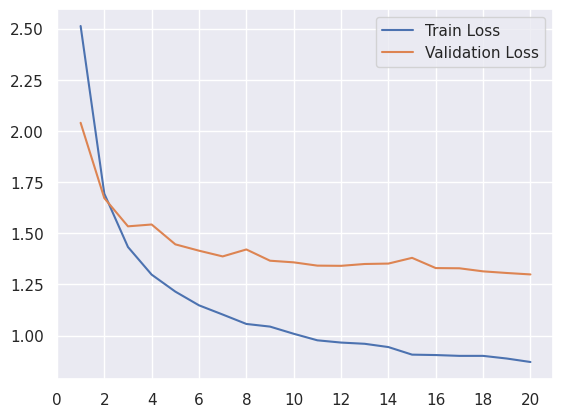

In [ ]:
plt.figure()
plt.plot(range(1,len(training_loss)+1), training_loss, label = 'Train Loss')
plt.plot(range(1,len(validation_loss)+1), validation_loss, label = 'Validation Loss')
plt.xticks(np.arange(0, 21, 2))
plt.legend()
plt.show()

## Tuning Hyperparameters

- Sử dụng Optuna để tuning hyperparameters cho model seq2seq kết hợp attention.

In [ ]:
def objective(trial):
    """
    Objective function to be optimized by Optuna.
    Hyperparameters chosen to be optimized: Learning rate, Batch size, Dropout value.
    """
    # Define range of values to be tested for the hyperparameters
    learning_rate = trial.suggest_float('lr', 0.0001, 0.005)
    batch_size = trial.suggest_categorical('batch_size', [128,256])
    drop_out = trial.suggest_float('drop_out', 0.1, 0.3)
    hidden_dim = trial.suggest_categorical('hidden_dim',[128,256,512])

    global encoder, decoder, encoder_optimizer, decoder_optimizer, loss_fn

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
    val_dataloader = DataLoader(valid_dataset, batch_size=batch_size)

    # Generate the model
    encoder = EncoderAtt(INPUT_DIM, hidden_dim, dropout = drop_out).to(device)
    decoder = DecoderAtt(hidden_dim, OUTPUT_DIM, dropout = drop_out).to(device)

    # Generate optimizer
    encoder_optimizer = torch.optim.AdamW(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = torch.optim.AdamW(decoder.parameters(), lr=learning_rate)
    loss_fn = nn.NLLLoss()

    num_epochs = 10
    validation_loss = []
    for epoch in range(num_epochs):
        start_time = time.time()
        train_loss = train_model(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, loss_fn, device, disable = False)
        valid_loss = evaluate_model(val_dataloader, encoder, decoder, loss_fn, device)
        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        if epoch % 5 == 0:
            print(f"Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s")
            print(f"\tTrain Loss: {train_loss:.3f} | Val. Loss: {valid_loss:.3f}")

        validation_loss.append(valid_loss)

    torch.save(encoder.state_dict(), f'./tuning/encoder_{learning_rate}_{batch_size}_{drop_out}.pt')
    torch.save(decoder.state_dict(), f'./tuning/decoder_{learning_rate}_{batch_size}_{drop_out}.pt')

    return np.min(validation_loss)

In [ ]:
## Folder to save checkpoints of tuning hyperparameters
if not os.path.exists("./tuning"):
    os.mkdir("./tuning")
number_of_trials = 10

# Create an Optuna study to maximize validation accuracy
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=number_of_trials)

# -------------------------------------------------------------------------
# Results
# -------------------------------------------------------------------------

trial = study.best_trial
print("Best trial:")
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-01-12 13:20:26,427] A new study created in memory with name: no-name-3925a1d5-0d92-4d4f-9b2c-ac1bfbe00cc6
100%|██████████| 1821/1821 [03:16<00:00,  9.25it/s, loss=2.37] 


Epoch: 01 | Epoch Time: 3m 28s
	Train Loss: 2.158 | Val. Loss: 1.821


100%|██████████| 1821/1821 [03:15<00:00,  9.29it/s, loss=1.79] 


Epoch: 06 | Epoch Time: 3m 28s
	Train Loss: 1.252 | Val. Loss: 1.583


100%|██████████| 1821/1821 [03:16<00:00,  9.25it/s, loss=2.44] 
[I 2024-01-12 13:55:13,708] Trial 0 finished with value: 1.4928828268437773 and parameters: {'lr': 0.0030923713745102627, 'batch_size': 128, 'drop_out': 0.10411279188438397, 'hidden_dim': 512}. Best is trial 0 with value: 1.4928828268437773.
100%|██████████| 911/911 [00:58<00:00, 15.45it/s, loss=3.32]


Epoch: 01 | Epoch Time: 1m 4s
	Train Loss: 2.933 | Val. Loss: 2.661


100%|██████████| 911/911 [00:58<00:00, 15.48it/s, loss=2.64] 


Epoch: 06 | Epoch Time: 1m 4s
	Train Loss: 1.551 | Val. Loss: 1.673


100%|██████████| 911/911 [00:59<00:00, 15.36it/s, loss=2]    
[I 2024-01-12 14:05:58,845] Trial 1 finished with value: 1.5773259135516915 and parameters: {'lr': 0.002603997118196936, 'batch_size': 256, 'drop_out': 0.13600998242387352, 'hidden_dim': 128}. Best is trial 0 with value: 1.4928828268437773.
100%|██████████| 1821/1821 [01:43<00:00, 17.63it/s, loss=3.34]


Epoch: 01 | Epoch Time: 1m 50s
	Train Loss: 2.630 | Val. Loss: 2.208


100%|██████████| 1821/1821 [01:43<00:00, 17.59it/s, loss=2.59] 


Epoch: 06 | Epoch Time: 1m 50s
	Train Loss: 1.380 | Val. Loss: 1.603


100%|██████████| 1821/1821 [01:43<00:00, 17.57it/s, loss=1.84] 
[I 2024-01-12 14:24:28,151] Trial 2 finished with value: 1.5644155491042782 and parameters: {'lr': 0.002789539058981127, 'batch_size': 128, 'drop_out': 0.15917189124487294, 'hidden_dim': 256}. Best is trial 0 with value: 1.4928828268437773.
100%|██████████| 911/911 [02:50<00:00,  5.34it/s, loss=3.03]


Epoch: 01 | Epoch Time: 3m 1s
	Train Loss: 2.269 | Val. Loss: 1.956


100%|██████████| 911/911 [02:50<00:00,  5.34it/s, loss=1.79] 


Epoch: 06 | Epoch Time: 3m 1s
	Train Loss: 1.345 | Val. Loss: 1.616


100%|██████████| 911/911 [02:50<00:00,  5.34it/s, loss=1.54] 
[I 2024-01-12 14:54:45,201] Trial 3 finished with value: 1.6157197299841288 and parameters: {'lr': 0.0038547728161618176, 'batch_size': 256, 'drop_out': 0.2912435949357298, 'hidden_dim': 512}. Best is trial 0 with value: 1.4928828268437773.
100%|██████████| 1821/1821 [03:16<00:00,  9.26it/s, loss=3]   


Epoch: 01 | Epoch Time: 3m 28s
	Train Loss: 2.353 | Val. Loss: 2.067


100%|██████████| 1821/1821 [03:16<00:00,  9.28it/s, loss=2]    


Epoch: 06 | Epoch Time: 3m 28s
	Train Loss: 1.456 | Val. Loss: 1.756


100%|██████████| 1821/1821 [03:16<00:00,  9.29it/s, loss=1.91] 
[I 2024-01-12 15:29:28,334] Trial 4 finished with value: 1.7559884915480743 and parameters: {'lr': 0.004047570074009537, 'batch_size': 128, 'drop_out': 0.2923071799690863, 'hidden_dim': 512}. Best is trial 0 with value: 1.4928828268437773.
100%|██████████| 1821/1821 [01:43<00:00, 17.58it/s, loss=3.52]


Epoch: 01 | Epoch Time: 1m 50s
	Train Loss: 3.129 | Val. Loss: 2.859


100%|██████████| 1821/1821 [01:43<00:00, 17.60it/s, loss=2.6] 


Epoch: 06 | Epoch Time: 1m 50s
	Train Loss: 2.029 | Val. Loss: 1.975


100%|██████████| 1821/1821 [01:43<00:00, 17.59it/s, loss=2.93]
[I 2024-01-12 15:47:52,726] Trial 5 finished with value: 1.7449856191068083 and parameters: {'lr': 0.00017309264689034548, 'batch_size': 128, 'drop_out': 0.20195102927604958, 'hidden_dim': 256}. Best is trial 0 with value: 1.4928828268437773.
100%|██████████| 1821/1821 [03:17<00:00,  9.22it/s, loss=2.91]


Epoch: 01 | Epoch Time: 3m 29s
	Train Loss: 2.262 | Val. Loss: 1.901


100%|██████████| 1821/1821 [03:17<00:00,  9.20it/s, loss=1.84] 


Epoch: 06 | Epoch Time: 3m 30s
	Train Loss: 1.229 | Val. Loss: 1.482


100%|██████████| 1821/1821 [03:17<00:00,  9.22it/s, loss=2.36] 
[I 2024-01-12 16:22:53,502] Trial 6 finished with value: 1.4236825108528137 and parameters: {'lr': 0.0010537195750384984, 'batch_size': 128, 'drop_out': 0.28994263288028566, 'hidden_dim': 512}. Best is trial 6 with value: 1.4236825108528137.
100%|██████████| 1821/1821 [03:16<00:00,  9.26it/s, loss=2.44]


Epoch: 01 | Epoch Time: 3m 28s
	Train Loss: 2.303 | Val. Loss: 1.921


100%|██████████| 1821/1821 [03:17<00:00,  9.23it/s, loss=2.56] 


Epoch: 06 | Epoch Time: 3m 29s
	Train Loss: 1.231 | Val. Loss: 1.482


100%|██████████| 1821/1821 [03:17<00:00,  9.24it/s, loss=1.57] 
[I 2024-01-12 16:57:49,218] Trial 7 finished with value: 1.4307959832855173 and parameters: {'lr': 0.0009120724531652456, 'batch_size': 128, 'drop_out': 0.2834486408160874, 'hidden_dim': 512}. Best is trial 6 with value: 1.4236825108528137.
100%|██████████| 911/911 [01:21<00:00, 11.13it/s, loss=2.67]


Epoch: 01 | Epoch Time: 1m 27s
	Train Loss: 2.679 | Val. Loss: 2.214


100%|██████████| 911/911 [01:22<00:00, 11.10it/s, loss=2.51] 


Epoch: 06 | Epoch Time: 1m 28s
	Train Loss: 1.495 | Val. Loss: 1.697


100%|██████████| 911/911 [01:21<00:00, 11.16it/s, loss=1.87] 
[I 2024-01-12 17:12:28,507] Trial 8 finished with value: 1.635909928663357 and parameters: {'lr': 0.0042111960375600995, 'batch_size': 256, 'drop_out': 0.2540688520025385, 'hidden_dim': 256}. Best is trial 6 with value: 1.4236825108528137.
100%|██████████| 911/911 [02:49<00:00,  5.36it/s, loss=3.5] 


Epoch: 01 | Epoch Time: 3m 0s
	Train Loss: 3.155 | Val. Loss: 2.874


100%|██████████| 911/911 [02:51<00:00,  5.32it/s, loss=2.95]


Epoch: 06 | Epoch Time: 3m 2s
	Train Loss: 2.013 | Val. Loss: 1.958


100%|██████████| 911/911 [02:50<00:00,  5.34it/s, loss=2.32] 
[I 2024-01-12 17:42:45,523] Trial 9 finished with value: 1.6781934411139101 and parameters: {'lr': 0.00015676427078948612, 'batch_size': 256, 'drop_out': 0.12907231547650233, 'hidden_dim': 512}. Best is trial 6 with value: 1.4236825108528137.


Best trial:
  Value:  1.4236825108528137
  Params: 
    lr: 0.0010537195750384984
    batch_size: 128
    drop_out: 0.28994263288028566
    hidden_dim: 512


## Evaluation

### Final Model

Sau khi đã tìm được bộ siêu tham số phù hợp, ta có final model tương ứng và thực hiện train lại model này.

In [ ]:
## Define Model Seq2Seq with Attention
INPUT_DIM = len(vocab_source)
OUTPUT_DIM = len(vocab_target)

batch_size_tuning = 256
hidden_dim_tuning = 512
drop_out_tuning = 0.2
learning_rate_tuning =  0.001

train_dataloader = DataLoader(train_dataset, batch_size=batch_size_tuning)
val_dataloader = DataLoader(valid_dataset, batch_size=batch_size_tuning)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size_tuning)

# Generate the model
encoder = EncoderAtt(INPUT_DIM, hidden_dim_tuning, dropout = drop_out_tuning).to(device)
decoder = DecoderAtt(hidden_dim_tuning, OUTPUT_DIM, dropout = drop_out_tuning).to(device)

# Generate optimizer
encoder_optimizer = torch.optim.AdamW(encoder.parameters(), lr=learning_rate_tuning)
decoder_optimizer = torch.optim.AdamW(decoder.parameters(), lr=learning_rate_tuning)
loss_fn = nn.NLLLoss()

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The encoder has {count_parameters(encoder):,} trainable parameters')
print(f'The decoder has {count_parameters(decoder):,} trainable parameters')

The encoder has 943,104 trainable parameters
The decoder has 9,483,733 trainable parameters


In [ ]:
training_loss = [2.504,1.706,1.453,1.339,1.242,1.197,1.146,1.135,1.092,1.072,1.037,1.035,1.025,1.004,0.978,0.964,0.961]
validation_loss = [2.060,1.715,1.609,1.554,1.476,1.474,1.449,1.430,1.414,1.402,1.401,1.403,1.391,1.364,1.361,1.362,1.342]

In [ ]:
training_loss, validation_loss = fit_model(encoder, decoder, train_dataloader, val_dataloader, encoder_optimizer, decoder_optimizer, loss_fn, device, num_epochs = 25, disable = False)

100%|██████████| 1008/1008 [03:00<00:00,  5.58it/s, loss=2.69]


Epoch: 01 | Epoch Time: 3m 7s
	Train Loss: 2.504 | Val. Loss: 2.060


100%|██████████| 1008/1008 [03:01<00:00,  5.56it/s, loss=2.33]


Epoch: 02 | Epoch Time: 3m 8s
	Train Loss: 1.706 | Val. Loss: 1.715


100%|██████████| 1008/1008 [03:01<00:00,  5.56it/s, loss=2.11]


Epoch: 03 | Epoch Time: 3m 8s
	Train Loss: 1.453 | Val. Loss: 1.609


100%|██████████| 1008/1008 [03:01<00:00,  5.54it/s, loss=2.64]


Epoch: 04 | Epoch Time: 3m 8s
	Train Loss: 1.339 | Val. Loss: 1.554


100%|██████████| 1008/1008 [03:01<00:00,  5.56it/s, loss=1.89]


Epoch: 05 | Epoch Time: 3m 8s
	Train Loss: 1.242 | Val. Loss: 1.476


100%|██████████| 1008/1008 [03:01<00:00,  5.56it/s, loss=2.5]


Epoch: 06 | Epoch Time: 3m 8s
	Train Loss: 1.197 | Val. Loss: 1.474


100%|██████████| 1008/1008 [03:01<00:00,  5.56it/s, loss=1.71]


Epoch: 07 | Epoch Time: 3m 8s
	Train Loss: 1.146 | Val. Loss: 1.449


100%|██████████| 1008/1008 [03:01<00:00,  5.55it/s, loss=1.69]


Epoch: 08 | Epoch Time: 3m 8s
	Train Loss: 1.135 | Val. Loss: 1.430


100%|██████████| 1008/1008 [03:01<00:00,  5.56it/s, loss=1.56]


Epoch: 09 | Epoch Time: 3m 8s
	Train Loss: 1.092 | Val. Loss: 1.414


100%|██████████| 1008/1008 [03:01<00:00,  5.54it/s, loss=1.54]


Epoch: 10 | Epoch Time: 3m 8s
	Train Loss: 1.072 | Val. Loss: 1.402


100%|██████████| 1008/1008 [03:01<00:00,  5.56it/s, loss=1.49]


Epoch: 11 | Epoch Time: 3m 8s
	Train Loss: 1.037 | Val. Loss: 1.401


100%|██████████| 1008/1008 [03:01<00:00,  5.56it/s, loss=1.44]


Epoch: 12 | Epoch Time: 3m 8s
	Train Loss: 1.035 | Val. Loss: 1.403


100%|██████████| 1008/1008 [03:02<00:00,  5.53it/s, loss=1.55]


Epoch: 13 | Epoch Time: 3m 9s
	Train Loss: 1.025 | Val. Loss: 1.391


100%|██████████| 1008/1008 [03:01<00:00,  5.55it/s, loss=2.39]


Epoch: 14 | Epoch Time: 3m 8s
	Train Loss: 1.004 | Val. Loss: 1.364


100%|██████████| 1008/1008 [03:01<00:00,  5.57it/s, loss=1.46]


Epoch: 15 | Epoch Time: 3m 7s
	Train Loss: 0.978 | Val. Loss: 1.361


100%|██████████| 1008/1008 [03:01<00:00,  5.57it/s, loss=1.37]


Epoch: 16 | Epoch Time: 3m 7s
	Train Loss: 0.964 | Val. Loss: 1.362


100%|██████████| 1008/1008 [03:01<00:00,  5.57it/s, loss=1.3]


Epoch: 17 | Epoch Time: 3m 7s
	Train Loss: 0.961 | Val. Loss: 1.342


100%|██████████| 1008/1008 [03:01<00:00,  5.57it/s, loss=1.29]


Epoch: 18 | Epoch Time: 3m 7s
	Train Loss: 0.945 | Val. Loss: 1.341


100%|██████████| 1008/1008 [03:01<00:00,  5.56it/s, loss=1.34]


Epoch: 19 | Epoch Time: 3m 8s
	Train Loss: 0.944 | Val. Loss: 1.341


100%|██████████| 1008/1008 [03:01<00:00,  5.56it/s, loss=1.24]


Epoch: 20 | Epoch Time: 3m 8s
	Train Loss: 0.934 | Val. Loss: 1.331


100%|██████████| 1008/1008 [03:01<00:00,  5.56it/s, loss=2.07]


Epoch: 21 | Epoch Time: 3m 8s
	Train Loss: 0.921 | Val. Loss: 1.336


100%|██████████| 1008/1008 [03:01<00:00,  5.54it/s, loss=2.07]


Epoch: 22 | Epoch Time: 3m 8s
	Train Loss: 0.929 | Val. Loss: 1.306


100%|██████████| 1008/1008 [03:01<00:00,  5.54it/s, loss=2.11]


Epoch: 23 | Epoch Time: 3m 8s
	Train Loss: 0.923 | Val. Loss: 1.320


100%|██████████| 1008/1008 [03:01<00:00,  5.56it/s, loss=1.26]


Epoch: 24 | Epoch Time: 3m 8s
	Train Loss: 0.914 | Val. Loss: 1.314


100%|██████████| 1008/1008 [03:01<00:00,  5.56it/s, loss=1.97]


Epoch: 25 | Epoch Time: 3m 8s
	Train Loss: 0.905 | Val. Loss: 1.314


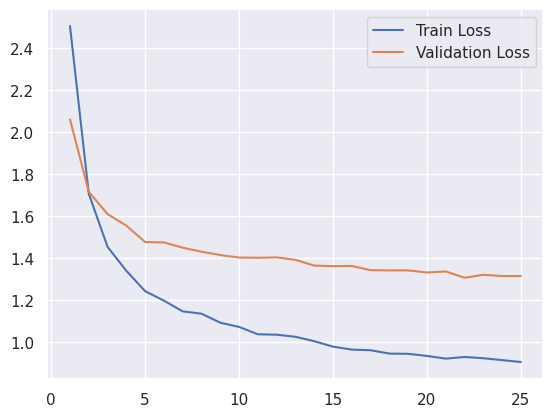

In [7]:
plt.figure()
plt.plot(range(1,len(training_loss)+1), training_loss, label = 'Train Loss')
plt.plot(range(1,len(validation_loss)+1), validation_loss, label = 'Validation Loss')
plt.legend()
plt.show()

### Inference

In [ ]:
def evaluate_final_model(sentence, encoder, decoder, vocab_source, vocab_target, disable = False):
    """ Evaluation Model
    @param encoder (EncoderAtt)
    @param decoder (DecoderAtt)
    @param sentence (str)
    @param vocab_source (Vocabulary)
    @param vocab_target (Vocabulary)
    @param disable (bool)
    """
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        input_tensor = vocab_source.corpus_to_tensor([sentence], disable = disable)[0].view(1,-1).to(device)

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == vocab_target.eos_id:
                decoded_words.append('<eos>')
                break
            decoded_words.append(vocab_target.id2word[idx.item()])
    return decoded_words, decoder_attn

def translate_sentence(sentence):
    output_words, _ = evaluate_final_model(sentence, encoder, decoder, vocab_source, vocab_target, disable= True)
    if "<pad>" in output_words:
      output_words.remove("<pad>")
    if "<unk>" in output_words:
      output_words.remove("<unk>")
    if "<sos>" in output_words:
      output_words.remove("<sos>")
    if "<eos>" in output_words:
      output_words.remove("<eos>")

    return ' '.join(output_words).capitalize()

In [ ]:
# Inference
for i in range(10000, 20000, 1000):
    sentence = test_dataset.sources[i]
    print(f"Sentence: {sentence}")
    print(f"Translation: {translate_sentence(sentence)}")
    print(f"Target: {test_dataset.targets[i]}")
    print()

Sentence: Swimming is good exercise for the whole body.
Translation: Bơi thì là bài tập tốt cho cho cơ thể thể thể .
Target: Bơi lội là bài tập tốt cho toàn cơ thể.

Sentence: The clock is wrong
Translation: Đồng hồ sai .
Target: đồng hồ sai

Sentence: I'll meet Tom at the library.
Translation: Tôi sẽ gặp tom ở thư viện .
Target: Tôi sẽ gặp tom tại thư viện.

Sentence: The bomb missed its target.
Translation: Bom bom đã mục đích mục tiêu .
Target: quả bom đã trượt mục tiêu.

Sentence: He put on sunglasses to protect his eyes from ultraviolet rays
Translation: Ông đeo kính râm để bảo vệ mắt khỏi tia xạ xạ xạ .
Target: anh đeo kính râm để bảo vệ mắt khỏi tia cực tím

Sentence: They weren't warned of the tidal wave
Translation: Họ không phải lo lắng về sự chấm của của
Target: họ không cảnh báo về sóng thủy triều

Sentence: I've lost the will to live
Translation: Tôi đã mất mất sống sẽ sống .
Target: tôi đã mất ý chí sống

Sentence: He comes to school by bus or train.
Translation: Anh ấy đ

In [ ]:
## English Sentences
srcs = []
for sent in test_dataset.sources:
    srcs.append(vocab_source.preprocessing_sent(sent, lang = 'en'))

## Predicted Sentences
translations = []
for sent in srcs:
    translations.append(translate_sentence(sent))

## Vietnamese Sentences
tgts = []
for sent in test_dataset.targets:
    tgts.append(vocab_source.preprocessing_sent(sent, lang = 'vi'))

### Metrics

Đánh giá các bản dịch được thực hiện theo hai phương diện:

- Adequacy (Thích hợp): Đo lường mức độ mà bản dịch hiện thực chính xác ý nghĩa chính xác của câu nguồn. Đôi khi được gọi là đáng tin cậy.

- Fluency (Lưu loát): Đo lường mức độ lưu loát của bản dịch trong ngôn ngữ đích (nó có ngữ pháp đúng, rõ ràng, dễ đọc, tự nhiên không).

Sử dụng con người (đánh giá bằng cách giao cho người đánh giá để đánh điểm trên một thang đo hoặc xếp hạng bằng cách hỏi họ xem họ thích phiên bản nào hơn) để đánh giá là chính xác nhất, nhưng cũng có sử dụng các độ đo tự động cho sự tiện lợi.

Nhóm em lựa chọn 2 metrics để đánh giá model là BLEU và BERTscore

#### BLEU

BLEU (Bilingual Evaluation Understudy) là một hàm số của độ chính xác từ theo n-gram trên tất cả các câu. Ý tưởng cốt lõi đằng sau BLEU là việc một bản dịch máy gần giống với một bản dịch chuyên nghiệp của con người thì nó càng tốt.


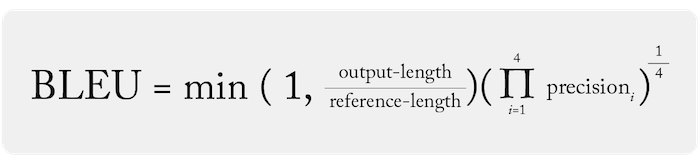

In [ ]:
## Using metric BLEU to evaluate our model
bleu = evaluate.load("bleu")
results = bleu.compute(predictions=translations, references=tgts)
print(results)

{'bleu': 0.3270885543628019, 'precisions': [0.6190670926517572, 0.4027881253940054, 0.26292880935949614, 0.17458576767695866], 'brevity_penalty': 1.0, 'length_ratio': 1.004604705701105, 'translation_length': 234750, 'reference_length': 233674}


#### BERTscore

BERTscore: một bản dịch tốt, có thể sử dụng các từ đồng nghĩa hoặc diễn đạt lại ý nghĩa, cho phép đồng nghĩa phù hợp giữa bản dịch tham chiếu $x$ và ứng cử viên $\hat{x}$. BERTscore đo đạc sự tương đồng giữa $x$ và $\hat{x}$ thông qua sự tương đồng của các nhúng (embeddings) của chúng.

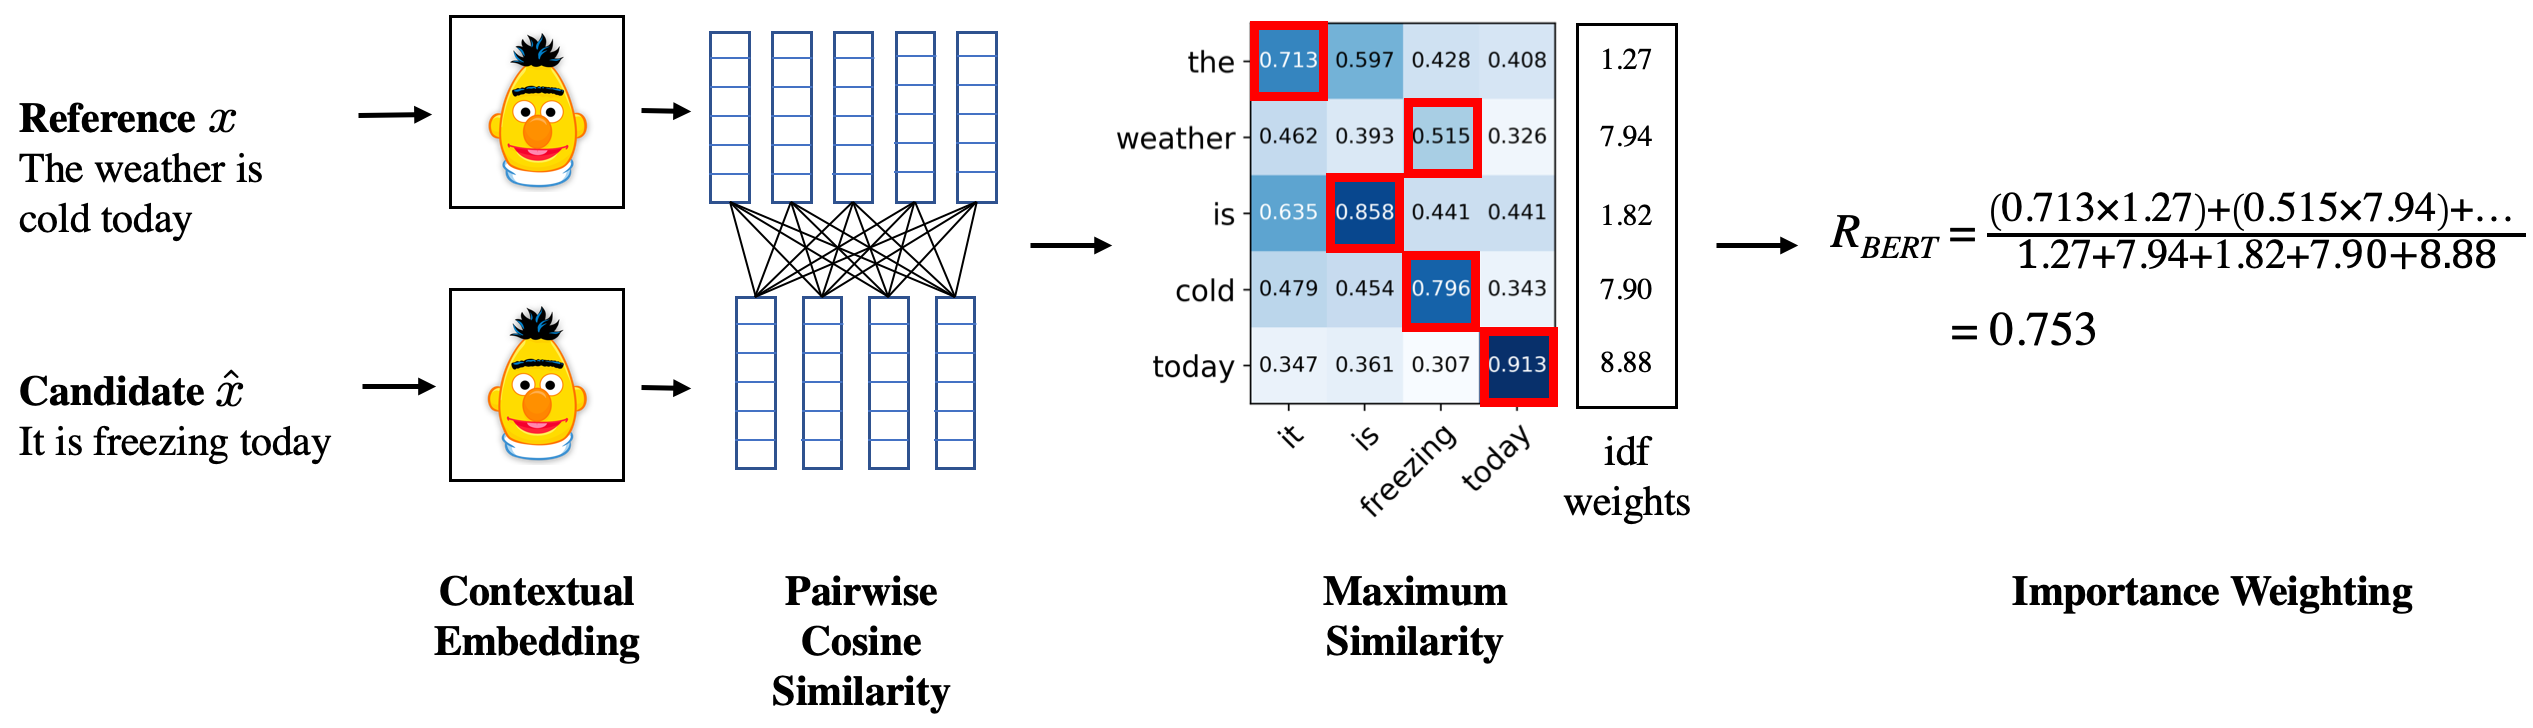

In [ ]:
# Final
cands = translations
refs = tgts
P, R, F1 = score(cands, refs, lang = 'vi')
print(f"Precision: {P.mean():.4f}")
print(f"Recall   : {R.mean():.4f}")
print(f"F1 Score : {F1.mean():.4f}")

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Precision: 0.8731
Recall   : 0.8718
F1 Score : 0.8722


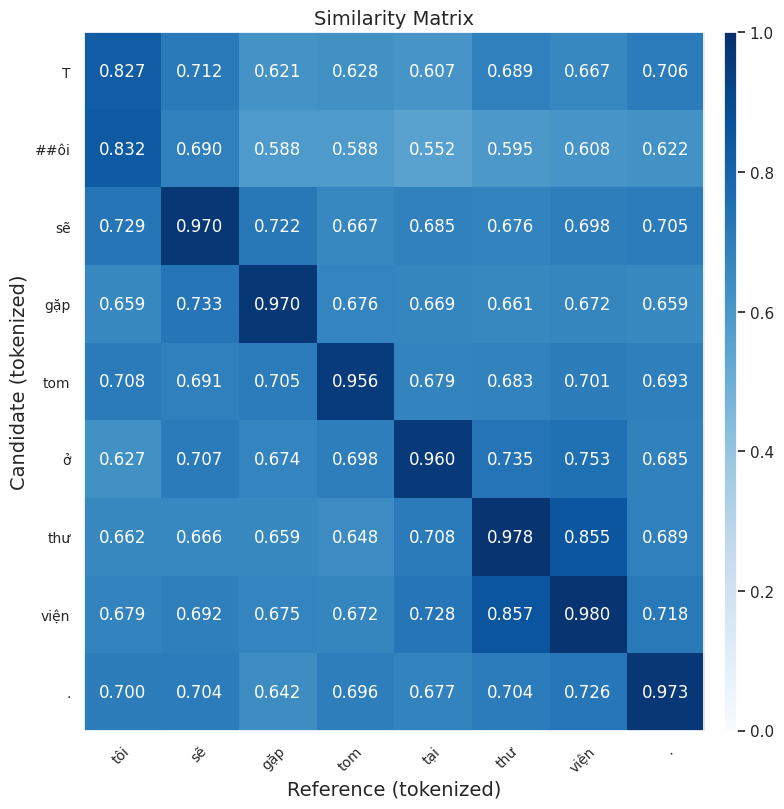

In [ ]:
# Sentence-level visualization by plotting the pairwise cosine similarity
cand = translations[12000]
ref = tgts[12000]
plot_example(cand, ref, lang="vi")

### Visualization

In [ ]:
def showAttention(input_sentence, output_words, attentions):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.cpu().numpy(), cmap='Blues')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels(['', '<sos>'] + input_sentence.split(' ') + ['<eos>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.show()

def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate_final_model(input_sentence, encoder, decoder, vocab_source, vocab_target, disable = True)
    print('Input = ', input_sentence)
    print('Output = ', ' '.join(output_words[1:-1]).capitalize())
    input_size = len(vocab_source.tokenize_corpus([input_sentence])[0])
    showAttention(input_sentence, output_words, attentions[0, :len(output_words), :input_size])

Input =  I will go to school
Output =  Tôi sẽ đi học .
Tokenize the corpus...


100%|██████████| 1/1 [00:00<00:00, 4917.12it/s]


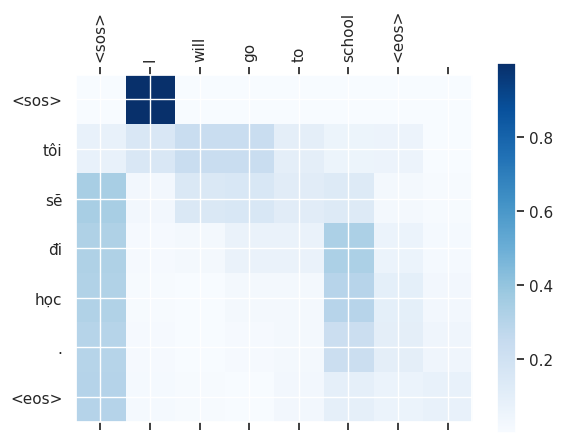

In [ ]:
# Final
evaluateAndShowAttention("I will go to school")

# Discussion and Analysis

## Performance

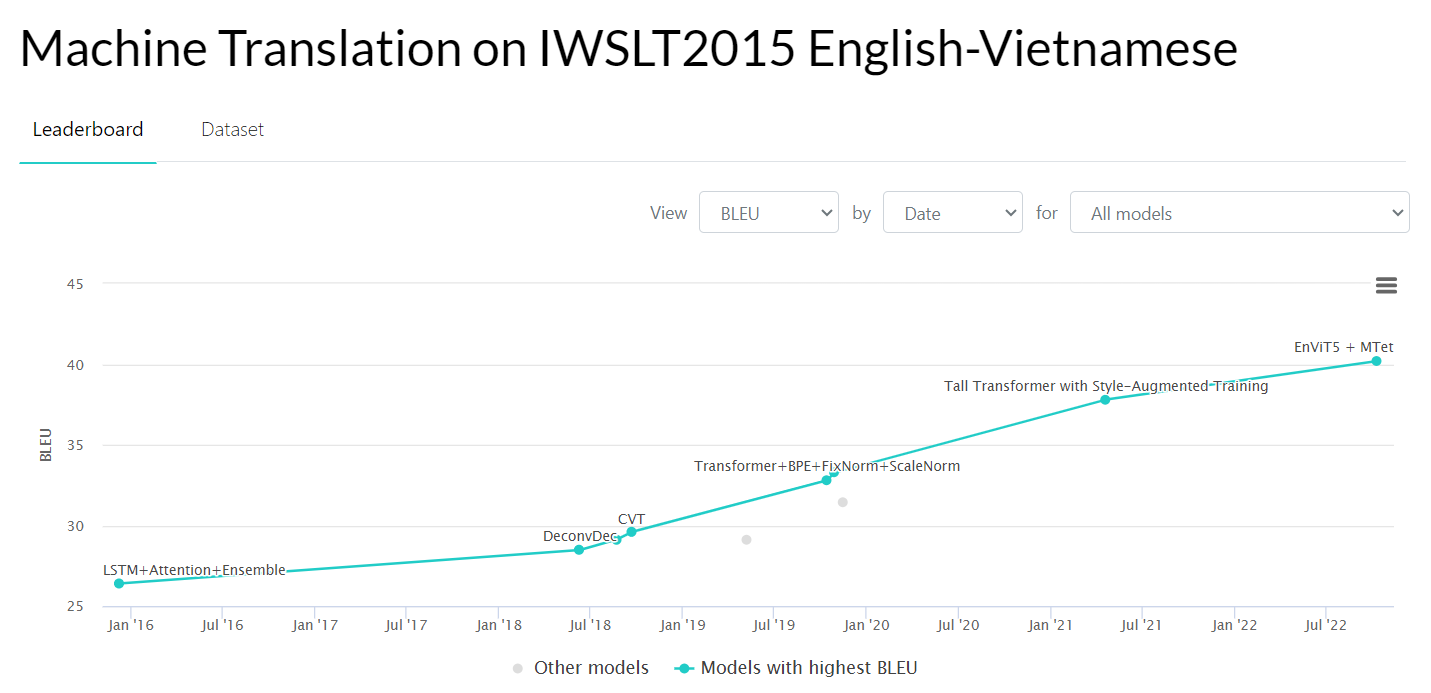

| BLEU | Precision | Recall | F1 |
|:------------------:|:------------------:|:------------------:|:------------------:|
| 32,71   | 0.8731        | 0.8718     | 0.8722

So sánh kết quả metric BLEU với các models khác, chúng em thấy tuy kiến trúc model còn đơn giản và tài nguyên hạn chế nhưng model của nhóm em đã có hiệu quả tương đối tốt.

Về metric BERTscore, các chỉ số Precision, Recall và F1 đều khá cao và gần ngang nhau.

## Challenges

- Kiến thức về các khái niệm, kỹ thuật, mô hình được sử dụng trong NLP nói chung và Machine Translation nói riêng mới được tiếp cận gần đây, các thành viên cần thời gian để tìm hiểu và học hỏi nhiều.
- Model có số lượng parameters lớn, tài nguyên hạn chế khiến nhóm thử được ít model và model còn đơn giản.
- Dataset song ngữ chất lượng cao với số lượng nhiều hiếm được công khai.

## Insights

Thông qua việc làm đồ án, chúng em đã gặt hái được một số bài học:
- Tăng kiến thức về RNN, đặc biệt là Encoder-Decoder.
- Mở rộng hiểu biết về NLP nói chung và Machine Translation nói riêng.
- Mỗi bài toán của NLP có cách tiền xử lý dữ liệu phù hợp.
- Domain của dataset ảnh hưởng đến văn phong, từ ngữ của câu được dịch, cùng domain thì sẽ dịch tốt hơn.
- Rèn luyện kỹ năng code python từ bước khám phá bộ dự liệu, chuẩn bị data, xây dựng model, train và đánh giá model, trực quan hóa.
- Áp dụng các kỹ thuật teacher forcing, transfer learning và tuning hyperparameters để cải tiến hiệu quả của model.

## Future Works

- Thử fine-tune pretrained model như Bert, mBart, BartPho để cải thiện BLEU, BERTscore.
- Sử dụng multi-domain dataset.
- Làm bài toán "ngược": dịch từ Tiếng Việt sang Tiếng Anh.